In [2]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import Dataset
import warnings
import copy
import torch.nn.functional as F
warnings.filterwarnings("ignore")

In [3]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [4]:
def make_txt_file(path):
    
    # Classes: train, eval, test
    classes = [i for i in os.listdir(path)]

    for i in classes:            
        s = 0
        dataset=open(i+'.txt', 'w')
        typepath=os.path.join(path, i)
        typenames=os.listdir(typepath)

        for typename in typenames:
            imgpath=os.path.join(typepath,typename)
            imgnames=os.listdir(imgpath)

            for imgname in imgnames:        
                name = imgpath + '/' + imgname + '-' + str(typenames.index(typename)) + '\n'  
                dataset.write(name)
        dataset.close()


In [5]:
class MyDataSet(Dataset):
    def __init__(self, dataset_type, transform=None, update_dataset=False):
        """
        dataset_type: [train, eval, test]
        """
 
        dataset_path = '/kaggle/input/caltech101/Caltech101/'
        read_path='/kaggle/working/'
 
        if update_dataset:
            make_txt_file(dataset_path)  # update datalist
 
        self.transform = transform
        self.sample_list = list()
        self.dataset_type = dataset_type
        f = open(read_path + self.dataset_type + '.txt')
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()
 
    def __getitem__(self, index):
        item = self.sample_list[index]
        img = Image.open(item.split('-')[0])
        img=img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = int(item.split('-')[-1])
        return img, label
 
    def __len__(self):
        return len(self.sample_list)

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomCrop((224,224),padding=16),
        torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data=MyDataSet('train',transform=data_transforms['train'],update_dataset=True)
eval_data=MyDataSet('eval',transform=data_transforms['eval'])
test_data=MyDataSet('test',transform=data_transforms['test'])

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride = 1,shortcut = None):

        super().__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(),
            nn.Conv2d(outchannel,outchannel,3,1,1,bias=False), 
            nn.BatchNorm2d(outchannel)
         )
        
        self.relu=nn.ReLU(inplace=True)
        self.right = shortcut

    def forward(self, input):
        out = self.left(input)
        residual = input if self.right is None else self.right(input)
        out+=residual
        return self.relu(out)

In [8]:
class ResNet(nn.Module):
        

    def __init__(self,num_class=1000):
        super().__init__()
    
        self.pre = nn.Sequential(
            nn.Conv2d(3,64,7,2,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1)
        )

            
        self.layer1 = self._make_layer(64,64,2)
        self.layer2 = self._make_layer(64,128,2,stride=2) 
        self.layer3 = self._make_layer(128,256,2,stride=2)
        self.layer4 = self._make_layer(256,512,2,stride=2)
        self.averagepool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(512,num_class)

    def _make_layer(self,inchannel,outchannel,block_num,stride = 1):
        
        if stride != 1 or inchannel != outchannel:
            shortcut = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
                nn.BatchNorm2d(outchannel)
            )
        else:
            shortcut=None 

        layers = []
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))

            
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))

        return nn.Sequential(*layers)


    def forward(self, input):
        x = self.pre(input)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.averagepool(x) 
                                
        x = x.view(x.size(0),-1)
        return self.fc(x)



In [9]:
BATCH_SIZE=64

train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=200,
                             shuffle=True, num_workers=2)
test_loader=Data.DataLoader(dataset=test_data,batch_size=200,
                             shuffle=True, num_workers=2)

In [10]:
def train(ResNet,train_loader,eval_loader,LR):
    setup_seed(20)
    res=ResNet(num_class=101).cuda()
    
    print('LR: ', LR)
    
    loss_func=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(res.parameters(), lr=LR, momentum=0.9)
    
    train_losses=[]
    eval_losses=[]
    train_accs=[]
    eval_accs=[]


    for epoch in range(35):
        res.train()  
        for step,(x,y) in enumerate(train_loader):
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()

            output=res(b_x)   
            loss=loss_func(output,b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 


        with torch.no_grad():
            res.eval()   

            accuracy=0
            data_size=0
            batch_loss=0
            for x,y in train_loader:
                b_x=Variable(x).cuda()
                b_y=Variable(y).cuda()        
                output=res(b_x)   
                pred_y=torch.max(output,1)[1].cuda().data.squeeze()
                accuracy+=sum(pred_y==b_y).double()
                data_size+=b_y.size(0)
                batch_loss+=loss_func(output,b_y).data*b_y.size(0)

                torch.cuda.empty_cache()

            train_acc=accuracy/data_size
            train_loss=batch_loss/data_size
            train_accs.append(train_acc)
            train_losses.append(train_loss)

            accuracy=0
            data_size=0
            batch_loss=0
            for x,y in eval_loader:
                b_x=Variable(x).cuda()
                b_y=Variable(y).cuda()        
                output=res(b_x)         
                pred_y=torch.max(output,1)[1].cuda().data.squeeze()
                accuracy+=sum(pred_y==b_y).double()
                data_size+=b_y.size(0)
                batch_loss+=loss_func(output,b_y).data*b_y.size(0)

                torch.cuda.empty_cache()

            eval_acc=accuracy/data_size
            eval_loss=batch_loss/data_size
            eval_accs.append(eval_acc)
            eval_losses.append(eval_loss)
            
            print('Epoch: %4s \n'%epoch,
              '| train loss: ',train_loss,
              '| Train_acc: %6s \n'% train_acc.data,
              '| eval loss: ',eval_loss,
              '| Eval_acc: %6s'%eval_acc.data)

    return train_losses,eval_losses,train_accs,eval_accs



In [11]:
LRS=[1,0.1,0.01,0.001]
loss_list=[]
acc_list=[]
for LR in LRS:
    train_los,eval_los,train_acc,eval_acc=train(ResNet,train_loader,eval_loader,LR)
    loss_list.append(train_los)
    loss_list.append(eval_los)
    acc_list.append(train_acc)
    acc_list.append(eval_acc)


LR:  1
Epoch:    0 
 | train loss:  tensor(4.2441, device='cuda:0') | Train_acc: tensor(0.0899, device='cuda:0', dtype=torch.float64) 
 | eval loss:  tensor(4.1812, device='cuda:0') | Eval_acc: tensor(0.0976, device='cuda:0', dtype=torch.float64)
Epoch:    1 
 | train loss:  tensor(4.2325, device='cuda:0') | Train_acc: tensor(0.0909, device='cuda:0', dtype=torch.float64) 
 | eval loss:  tensor(4.1880, device='cuda:0') | Eval_acc: tensor(0.0976, device='cuda:0', dtype=torch.float64)
Epoch:    2 
 | train loss:  tensor(4.2136, device='cuda:0') | Train_acc: tensor(0.0953, device='cuda:0', dtype=torch.float64) 
 | eval loss:  tensor(4.1751, device='cuda:0') | Eval_acc: tensor(0.0951, device='cuda:0', dtype=torch.float64)
Epoch:    3 
 | train loss:  tensor(4.1821, device='cuda:0') | Train_acc: tensor(0.1107, device='cuda:0', dtype=torch.float64) 
 | eval loss:  tensor(4.1661, device='cuda:0') | Eval_acc: tensor(0.1024, device='cuda:0', dtype=torch.float64)
Epoch:    4 
 | train loss:  tens

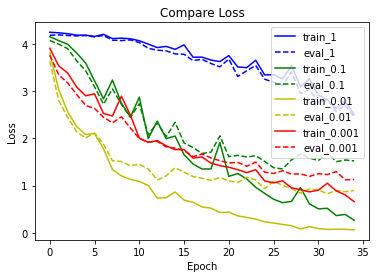

In [12]:
x=np.arange(35)
colors=['b-','b--','g-','g--','y-','y--','r-','r--']
for i in range(len(loss_list)):
    label1='train_' if i%2==0 else 'eval_'
    label2=str(LRS[i//2])    
    plt.plot(x,loss_list[i],colors[i],label=label1+label2)
    
plt.legend()
plt.title('Compare Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

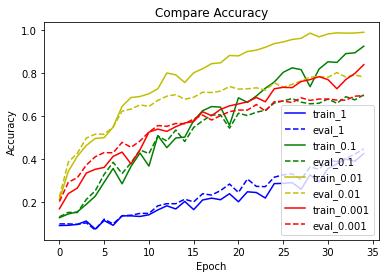

In [13]:
for i in range(len(acc_list)):
    label1='train_' if i%2==0 else 'eval_'
    label2=str(LRS[i//2])    
    plt.plot(x,acc_list[i],colors[i],label=label1+label2)
    
plt.legend()
plt.title('Compare Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()